Welcome to the hands-on lab for **Understanding SQL Injections**.

# What are SQL Injections?

SQL injection (SQLi) is a type of vulnerability in which the attacker accesses private information with SQL queries in the user input field that modify execution of SQL commands. 

From the video, you have learned that there are four types of SQL injections:
1. SQL manipulation
2. Code injection
3. Function call injection
4. Buffer overflows

In this lab, we will look at SQL manipulation, which is common in web applications.

# Learning Objectives

In this lab, you will:
* Identify SQL injection in a Python web application
* Use Bandit to scan for vulnerabilities in the Python source code
* Resolve SQL injection vulnerabilities by correcting the source code
* Retest code fixes to confirm that the vulnerability was mitigated

# Set up the Lab Environment

You have a little preparation to do before you can start the lab. We need to download and install a vulnerability scanner to test Python files for vulnerabilities.

For this lab, we will need:
* Bandit (Vulnerability scanner for Python files)
* Python package (Test files for scanning)


# Installing Bandit

* **[Bandit](https://bandit.readthedocs.io/en/latest/index.html)** is an open-source static application security testing (SAST) tool that can scan for vulnerabilities in web applications written in Python.
* Setting it up is very simple.

## Your Task

1. Open a Terminal shell using the top menu item `Terminal -> New Terminal`.
2. Navigate to the `/home/project` folder: **`cd /home/project`**
3. Use the Python Package manager (`pip`) to install the `bandit` package: **`pip install bandit`**

This tool will review the application’s source code to check for issues.

# Downloading the Source Code

* Now you need some source code to scan.
* Run the following command to download the source code for the application that we will be investigating in this lab.

## Your Task

1. Use the `wget` command to download the source code.

```
wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-CD0267EN-SkillsNetwork/labs/module3/web_app_example.py

```
    
    The command will save web_app_example.py to the current directory /home/project.
   
2. Open the file we just downloaded by double-clicking the **`web_app_example.py`** file in the explorer to view the code or simply press the button below.

    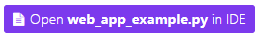

You are now ready to scan the file for vulnerabilities.

# Find the Vulnerability

* `Bandit` makes it easy to scan Python files inside the terminal window. 
* Let’s take a look at the vulnerabilities that exist in this web application.

## Your Task

Run the `bandit` command using the `-r` flag and passing in the name fo the file `web_app_example.py` as a parameter:

```
bandit -r web_app_example.py
```

## Results

The output should display something similar to this:

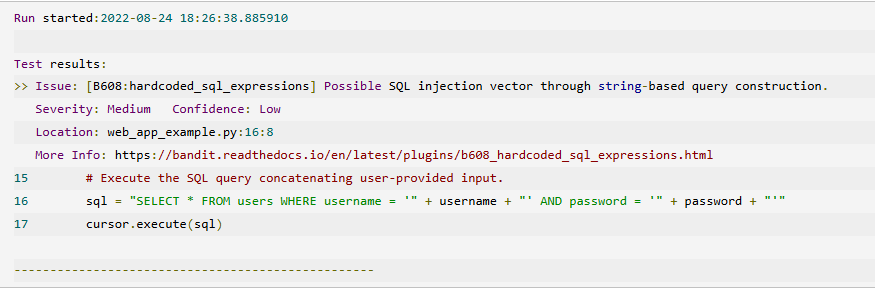

**What problems did `Bandit` report?**

## Hint

Bandit's analysis identifies the exact location of the vulnerability:
```
    Location: web_app_example.py:16:8
```

## Solution

* Under the **"Test results"** section, we see that **Bandit** has identified one issue - **"Possible SQL injection vector through string-based query construction"**. 
* **Bandit** also provided us with the exact location where the vulnerability occurred: **line 16**. 
* Now we're aware that the syntax used in the SQL query introduces risk. 
* Let's take a closer look at why the query was identified as a SQL injection vulnerability.

# Examine the SQL Injection

Let’s correlate the error message from **`bandit`** with the source code.

You can see that the vulnerability occurred on **`line 16`**. 

Open the code and examine **`line 16`** closely:

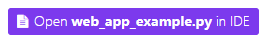

**`Line 16`** shows the following:
```
sql = "SELECT * FROM users WHERE username = '" + username + "' AND password = '" + password + "'"
cursor.execute(sql)
```

* In the line above, the user inputs for username and password were concatenated in the SQL query. 
* As a result, an attacker could enter a username input such as: **`' OR 1=1; --`**

This results in the following SQL query string:
```
"SELECT * FROM users WHERE username = '' OR 1=1; --' AND password = '%s'"
```

**What does this SQL query imply?**

Let’s examine each part separately:
* The first part **`SELECT * FROM users WHERE username = ''`** represents a complete query that returns any records in the database with **`username=''`**. This is a valid query which wouldn’t return anything as long as there are no empty string usernames.
* However, the condition **`OR 1=1;`** following it will always evaluate to **`TRUE`**, so the query will return all of the users in the table.
* The **`;`** marks the end of a query and the **`--`** after it would comment out the rest of the query string. Ultimately, the password entry wouldn’t even matter.

This isn’t the only way an attacker can hack the system. Using the same logic, one could also include additional SQL queries deleting the entire database with **`DROP`**, or gain admin access with **`UPDATE`** and **`SET`** as long as they comment out the undesired segments from the original query string.

# Mitigate the Vulnerability

* To prevent those issues, you’ll need to modify the code to use substitution parameters. 
* Substitution parameters allow you to put placeholders in the code that will be substituted for the variables that you pass to the SQL interpreter. 
* It’s important to note that the substitution parameters can be different for other SQL variants. 
* Check the documentation for the version of SQL you’re using. 
* In this case, we’re using **`%s`** as the placeholder for a string that will be substituted at execution time.

Let’s update **`web_app_example.py`** with this line of code by replacing lines **`16`** & **`17`** with the lines above.

## Your Task

Change the SQL query on lines 16 & 17 in the python code, not use string concatenation and use substitution placeholders **(`%s`)** instead:
```
sql = "SELECT * FROM users WHERE username = %s AND password = %s"
cursor.execute(sql, (username, password))
```

By eliminating string concatenation for username and password, this tells the SQL engine to interpret them as a string and not a command. This eliminates the possibility of SQL command injection.

Notice we also called a different form of **`cursor.execute()`** where it takes two parameters, the SQL string and a tuple of variables to be used with the placeholders **`%s`** as substitution paramaters.

# Check for Successful Fix

Now the moment of truth has come. 

**Did your changes fix the vulnerability?**

After saving our changes, it’s time to re-run **`Bandit`** to see if the problem was fixed.

## Your Task

Run the **`bandit`** command again with the **`-r`** flag passing in the file name:
```
bandit -r web_app_example.py
```

## Results

Your output should look something like this:

```
Test results:
        No issues identified.

Code scanned:
        Total lines of code: 14
        Total lines skipped (#nosec): 0

Run metrics:
        Total issues (by severity):
                Undefined: 0.0
                Low: 0.0
                Medium: 0.0
                High: 0.0
        Total issues (by confidence):
                Undefined: 0.0
                Low: 0.0
                Medium: 0.0
                High: 0.0
Files skipped (0):
```

## Success

We have successfully eliminated the SQL injection vulnerability by using parameter substitution instead of string concatenation!

# Preventing SQL Injection Attacks

Here are some recommendations for preventing SQLi when coding:

* **Prepared statements with parametrized queries**: this approach to writing SQL code forces developers to pass parameters separately into the query, which will prevent attackers from taking advantage of the SQL syntax.
* **Doublecheck imported packages**: PyPi is a great source for secure packages, but not all of them are verified. If a package isn’t as well-known, it’s good to do a little research on whether it is reliable or not.
* **Make a checklist of potential vulnerabilities**: this will help you stay mindful while coding.
* **Scan your application**: in addition to [static application security testing tools](https://owasp.org/www-community/Source_Code_Analysis_Tools) like **`Bandit`**, you can also utilize [dynamic application security testing tools](https://owasp.org/www-community/Vulnerability_Scanning_Tools) that will scan the web application using its URL while it’s running.


# Conclusion

Congratulations! You have learned how Bandit can help identify vulnerabilities residing in Python files.

SQL injection can be highly detrimental to a website’s database and its moderators. This vulnerability results in an attacker’s unauthorized access to and modification of user information - none of which is desired for its infringement on user privacy.

In this lab, you learned how to use Bandit to run a vulnerability scan to search for SQL injection (SQLi) vulnerabilities. You also learned how attackers manipulate SQL queries with user input that changes the results of the query’s output.

You learned how to mitigate these issues by using substitution parameters as placeholders in the code that substitutes the actual variables passed to the SQL interpreter. You learned how to correct the code to remove the vulnerability and retested with Bandit to prove that the issue was fixed.

# Next Steps

Use the bandit tool on your database projects to see if they contain any SQL vulnerabilities.

If you’re interested in learning more about SQL injection attacks, how to detect and prevent them, visit the following resources:
* **[OWASP SQL Injection Prevention Cheat Sheet](https://cheatsheetseries.owasp.org/cheatsheets/SQL_Injection_Prevention_Cheat_Sheet.html)**
* **[Query Parameterization Cheat Sheet](https://cheatsheetseries.owasp.org/cheatsheets/Query_Parameterization_Cheat_Sheet.html)**
* and the **[OWASP Web Security Testing Guide](https://owasp.org/www-project-web-security-testing-guide/)**